In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np
import os 
_URL = '[https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

BASE_DIR = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

print(f"Dataset extracted to: {BASE_DIR}")
print(f"Training images are in: {train_dir}")
print(f"Validation images are in: {validation_dir}")

Dataset extracted to: C:\Users\shank\.keras\datasets\cats_and_dogs_filtered
Training images are in: C:\Users\shank\.keras\datasets\cats_and_dogs_filtered\train
Validation images are in: C:\Users\shank\.keras\datasets\cats_and_dogs_filtered\validation


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.

Class names: ['cats', 'dogs']


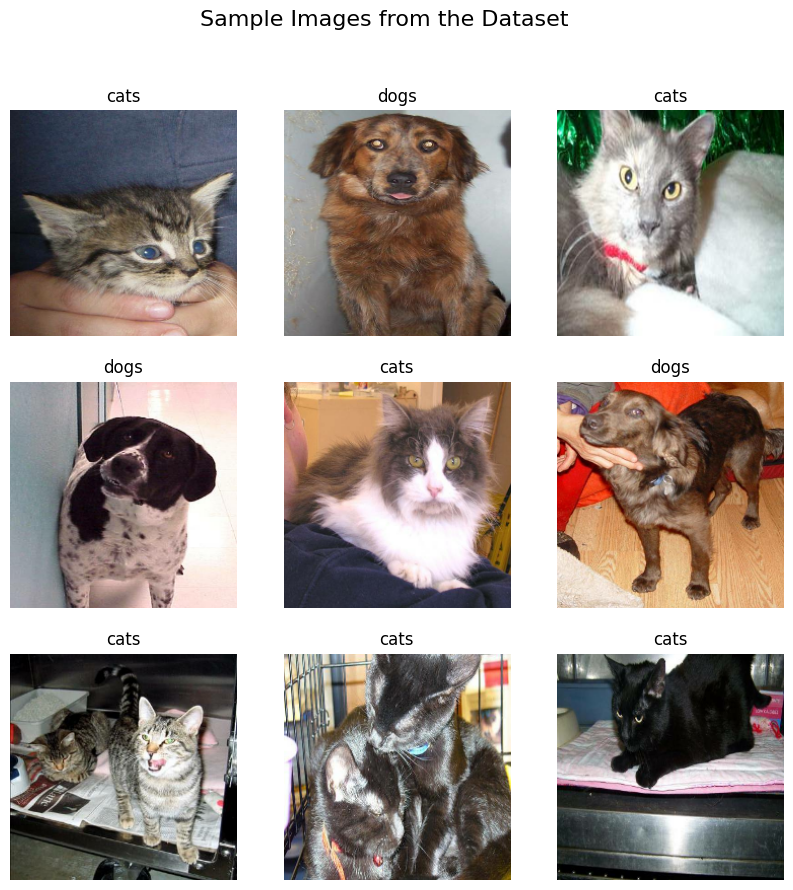

In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE 
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

class_names = train_dataset.class_names
print(f"\nClass names: {class_names}")

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from the Dataset", fontsize=16)
plt.show()

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)

In [12]:
base_model = VGG16(input_shape=IMG_SIZE + (3,),
                   include_top=False,
                   weights='imagenet')

base_model.trainable = False
global_average_layer = layers.GlobalAveragePooling2D() 
prediction_layer = layers.Dense(1, activation='sigmoid')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs) 
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print("VGG16-based Transfer Learning Model Summary:")
model.summary()

#

58889256/58889256 [==============================] - 43s 1us/step
VGG16-based Transfer Learning Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                

In [13]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10 
print(f"\nStarting model training for {initial_epochs} epochs...")
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)
print("Model training complete!")


Starting model training for 10 epochs...
Epoch 1/10
63/63 [==============================] - 563s 9s/step - loss: 2.5582 - accuracy: 0.5000 - val_loss: 2.1008 - val_accuracy: 0.5490
Epoch 2/10
63/63 [==============================] - 438s 7s/step - loss: 1.7738 - accuracy: 0.5790 - val_loss: 1.5291 - val_accuracy: 0.6330
Epoch 3/10
63/63 [==============================] - 396s 6s/step - loss: 1.3127 - accuracy: 0.6625 - val_loss: 1.1527 - val_accuracy: 0.7050
Epoch 4/10
63/63 [==============================] - 402s 6s/step - loss: 1.0072 - accuracy: 0.7290 - val_loss: 0.8974 - val_accuracy: 0.7430
Epoch 5/10
63/63 [==============================] - 374s 6s/step - loss: 0.8007 - accuracy: 0.7820 - val_loss: 0.7199 - val_accuracy: 0.7840
Epoch 6/10
63/63 [==============================] - 366s 6s/step - loss: 0.6575 - accuracy: 0.8115 - val_loss: 0.5939 - val_accuracy: 0.8140
Epoch 7/10
63/63 [==============================] - 393s 6s/step - loss: 0.5555 - accuracy: 0.8405 - val_loss: 0

32/32 [==============================] - 109s 3s/step - loss: 0.3351 - accuracy: 0.8780

Model Test Accuracy: 87.80%
Model Test Loss: 0.3351


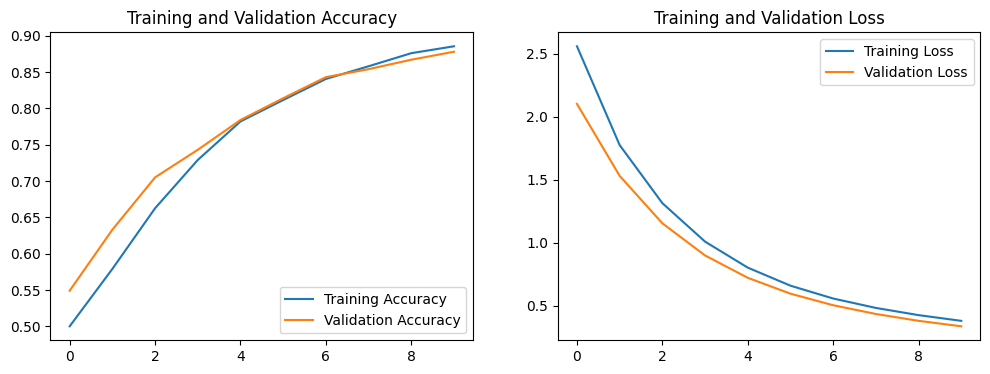

1/1 [==============================] - 4s 4s/step


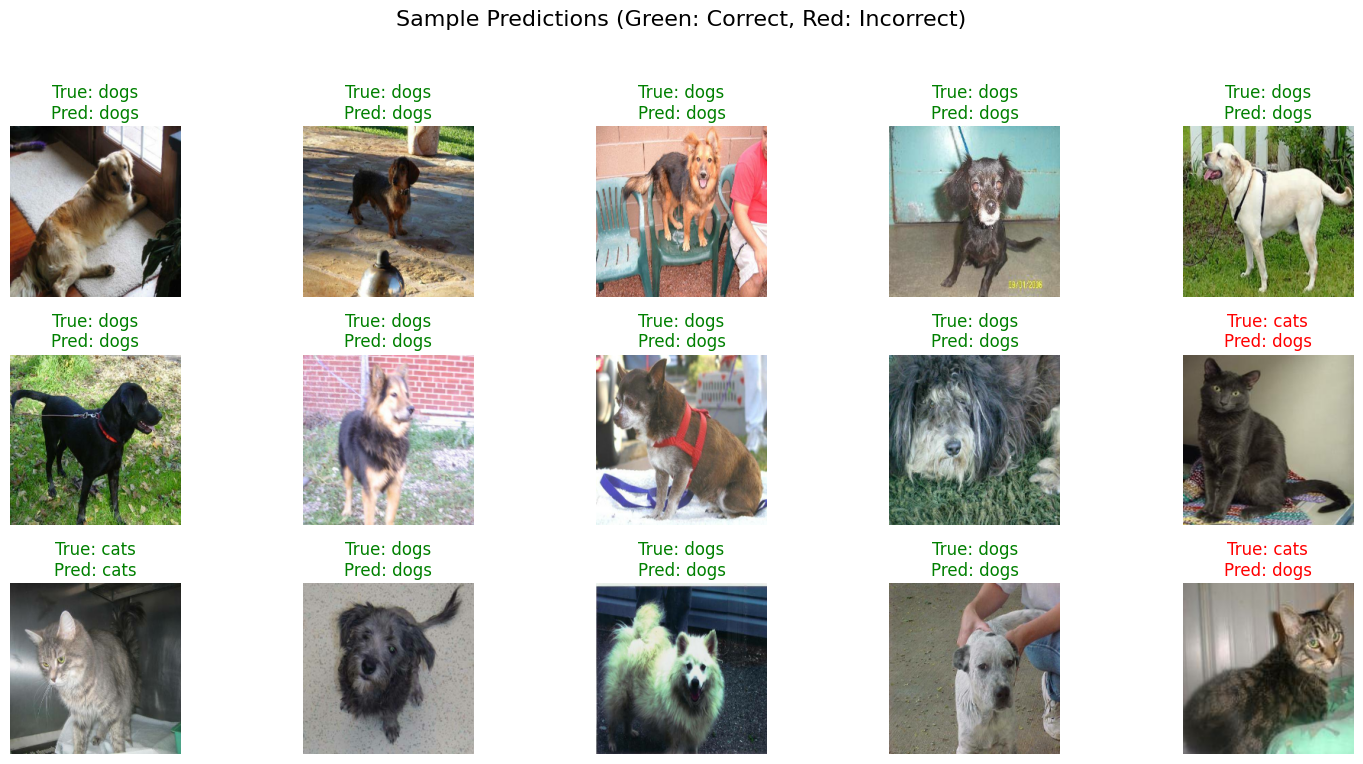

In [15]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"\nModel Test Accuracy: {accuracy*100:.2f}%")
print(f"Model Test Loss: {loss:.4f}")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
epochs_range = range(initial_epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

test_images, test_labels = next(iter(validation_dataset))

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype("int32")

true_labels_names = [class_names[i] for i in test_labels.numpy()]
predicted_labels_names = [class_names[i] for i in predicted_labels.flatten()]

plt.figure(figsize=(15, 8))
num_images_to_show = min(len(test_images), 15) 
for i in range(num_images_to_show):
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(f"True: {true_labels_names[i]}\nPred: {predicted_labels_names[i]}",
              color='green' if true_labels_names[i] == predicted_labels_names[i] else 'red')
    plt.axis("off")
plt.suptitle("Sample Predictions (Green: Correct, Red: Incorrect)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

In [16]:
model.save('exp4.h5')